<a href="https://colab.research.google.com/github/ashley-ferreira/PHYS449_FinalProject/blob/main/notebooks/KerasC2_our_data_40x_trial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 15.2 MB/s 
     |████████████████████████████████| 4.5 MB 75.9 MB/s 
     |████████████████████████████████| 885 kB 68.9 MB/s 
     |████████████████████████████████| 48 kB 2.1 MB/s 
     |████████████████████████████████| 4.0 MB 79.5 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284593 sha256=c1dce469ada6b66d47d34dc0eef98b1196c82bcab9f68ea19b9b82841106c018
  Stored in directory: /root/.cache/pip/wheels/f2/b6/1f/222aea123a5de8a34c3dd95bb73dca35e342ef3901328e9db0
Successfully built astroNN


In [2]:
#from astroNN.datasets import galaxy10
#from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
#Import google drive (need to put data folder as shortcut in your local drive My Drive):
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Full data**

In [4]:
#LOAD THE DATA FROM TXT FILE INTO A BATCH:
def data_batch(datafile_index, num_images=40, data_file='MyDrive/data_g_band.txt', plotting=False):
    '''
    Description:
        Access datafile.txt, each row is flattened 110x110 image + 1 label string (E, Sp, S0, Irr+Misc).
        Returns an augmented batch of num_images X 40.
        The labels are converted to 1D vectors (ex: Sp = [0,0,1,0])
        Need to give a datafile_index that tells which rows to pick.
    Inputs:
        datafile_index: index of row in datafile to load. loads rows datafile_index to datafile_index+num_images.
        num_images: number of different images to load per batch, total batch size 
        is 40 X num_images. (default: 10 (for 40X10 = 400 batch size like in paper)
        data_file: datafile full path, need to add shortcut to local Drive. (default: '/content/drive/MyDrive/data/data_g_band.txt')
    Outputs:
        tensor_input_batch_aug: dimensions: (100, 100, num_images X 40).
        tensor_label_batch_aug: dimensions: (num_images X 40, 4)
    '''

    #Take batch of num_images rows from datafile:
    with open(data_file, 'r') as f:
        rows = f.readlines()[datafile_index:(datafile_index+num_images)]

    #for batch size of 400 (augmented), need 10 images
    data_batch = np.zeros((num_images,12101), dtype=np.dtype('U10'))
    count = 0
    for row in rows:
        data_batch[count,:] = row.split()
        count += 1

    #separate label and input:
    input_batch_flat = np.array(data_batch[:,:12100], dtype=float)#, dtype=int)
    label_batch = np.array(data_batch[:,-1])

    #convert input batch back to a 2D array:
    input_batch = np.zeros((110,110,np.shape(input_batch_flat)[0]))#, dtype=int)
    for ii in range(np.shape(input_batch_flat)[0]):
        input_batch[:,:,ii] = np.reshape(input_batch_flat[ii,:], (110,110))


    #convert label batch into into 1D vector: 
    #E=0, S0=1, Sp=2, Irr+Misc=3
    #ex: label = [0,0,1,0] ==> Sp galagy
    arr_label_batch = np.zeros((np.shape(label_batch)[0],4), dtype=int)
    arr_label_batch[:,0] = np.array([label_batch == 'E'], dtype=int)
    arr_label_batch[:,1] = np.array([label_batch == 'Sp'], dtype=int)
    arr_label_batch[:,2] = np.array([label_batch == 'S0'], dtype=int)
    arr_label_batch[:,3] = np.array([label_batch == 'Irr+Misc'], dtype=int)

    if plotting == True:
      #test with image plotted
      plt.imshow(input_batch[:,:,0])
      plt.show()

    #NOW AUGMENT THE BATCH (40X more):
    input_batch_aug = np.empty((100,100,np.shape(input_batch)[2]*40), dtype=int)
    arr_label_batch_aug = np.empty((np.shape(arr_label_batch)[0]*40, 4), dtype=int)

    count = 0
    for ll in range(np.shape(input_batch)[2]):
        #Crop 5X more image (100X100 pixels)
        C1 = input_batch[:100,:100,ll]
        C2 = input_batch[10:,:100,ll]
        C3 = input_batch[:100,10:,ll]
        C4 = input_batch[10:,10:,ll]
        C5 = input_batch[5:105,5:105,ll]

        C = [C1, C2, C3, C4, C5]

        for kk in range(5):
            #Rotate 4X more image (by 90 deg)
            for jj in range(4):
                C_R = np.rot90(C[kk], k=jj)
                input_batch_aug[:,:,count] = C_R
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1
                
                input_batch_aug[:,:,count] = np.swapaxes(C_R,0,1)
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1


    #PUT THE DATA AS A PYTORCH TENSOR:
    #tensor_input_batch_aug = torch.Tensor(input_batch_aug)
    #tensor_label_batch_aug = torch.Tensor(arr_label_batch_aug)
    
    return input_batch_aug, arr_label_batch_aug

# **Our augmented data**

In [5]:
# #LESS DATA AUGMENTION: crop only = X5 augmentation:

# #AUGMENT ONLY X5 (ONLY BY CROPPING)
# def data_batch_aug5(datafile_index, num_images=10,  data_file='/content/drive/MyDrive/data_g_band.txt', plotting=False):
#     '''
#     Description:
#         Access datafile.txt, each row is flattened 110x110 image + 1 label string (E, Sp, S0, Irr+Misc).
#         Returns an augmented batch of num_images X 5.
#         The labels are converted to 1D vectors (ex: Sp = [0,0,1,0])
#         Need to give a datafile_index that tells which rows to pick.
#     Inputs:
#         datafile_index: index of row in datafile to load. loads rows datafile_index to datafile_index+num_images.
#         num_images: number of different images to load per batch, total batch size 
#         is 5 X num_images. (default: 10 (for 5X10 = 400 batch size like in paper)
#         data_file: datafile full path, need to add shortcut to local Drive. (default: '/content/drive/MyDrive/data/data_g_band.txt')
#     Outputs:
#         tensor_input_batch_aug: dimensions: (100, 100, num_images X 5). 
#         tensor_label_batch_aug: dimensions: (num_images X 5, 4)
#     '''

#     #data_file = 'data_g_band.txt'

#     #Take batch of num_images rows from datafile:
#     with open(data_file, 'r') as f:
#         rows = f.readlines()[datafile_index:(datafile_index+num_images)]

#     #for batch size of 400 (augmented), need 10 images
#     data_batch = np.zeros((num_images,12101), dtype=np.dtype('U10'))
#     count = 0
#     for row in rows:
#         data_batch[count,:] = row.split()
#         count += 1

#     #separate label and input:
#     input_batch_flat = np.array(data_batch[:,:12100], dtype=int)
#     label_batch = np.array(data_batch[:,-1])

#     #convert input batch back to a 2D array:
#     input_batch = np.empty((110,110,np.shape(input_batch_flat)[0]), dtype=int)
#     for ii in range(np.shape(input_batch_flat)[0]):
#         input_batch[:,:,ii] = np.reshape(input_batch_flat[ii,:], (110,110))


#     #convert label batch into into 1D vector: 
#     #E=0, S0=1, Sp=2, Irr+Misc=3
#     #ex: label = [0,0,1,0] ==> Sp galagy
#     arr_label_batch = np.empty((np.shape(label_batch)[0],4), dtype=int)
#     arr_label_batch[:,0] = np.array([label_batch == 'E'], dtype=int)
#     arr_label_batch[:,1] = np.array([label_batch == 'Sp'], dtype=int)
#     arr_label_batch[:,2] = np.array([label_batch == 'S0'], dtype=int)
#     arr_label_batch[:,3] = np.array([label_batch == 'Irr+Misc'], dtype=int)

#     #test with image plotted
#     if plotting == True:
#       plt.imshow(input_batch[:,:,0])
#       plt.show()

#     #NOW AUGMENT THE BATCH (5X more):
#     how_much_augment = 5
#     input_batch_aug = np.empty((100,100,np.shape(input_batch)[2]*how_much_augment), dtype=int)
#     arr_label_batch_aug = np.empty((np.shape(arr_label_batch)[0]*how_much_augment, 4), dtype=int)

#     count = 0
#     for ll in range(np.shape(input_batch)[2]):
#         #Crop 5X more image (100X100 pixels)
#         C1 = input_batch[:100,:100,ll]
#         C2 = input_batch[10:,:100,ll]
#         C3 = input_batch[:100,10:,ll]
#         C4 = input_batch[10:,10:,ll]
#         C5 = input_batch[5:105,5:105,ll]

#         C = [C1, C2, C3, C4, C5]

#         for kk in range(5):
#             input_batch_aug[:,:,count] = C[kk]
#             arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
#             count += 1

#     #PUT THE DATA AS A PYTORCH TENSOR:
#     #tensor_input_batch_aug = torch.Tensor(input_batch_aug)
#     #tensor_label_batch_aug = torch.Tensor(arr_label_batch_aug)
    
#     return input_batch_aug, arr_label_batch_aug

# '''
# #Test above function:
# rand_index = np.random.permutation(1403) #10 images
# rand_train = rand_index[:200] #arbitrary values
# rand_test = rand_index[200:]

# #Use this loop for training over entire dataset at each epochs
# for ii in range(np.shape(rand_train)[0]):
#   image_batch, label_batch = data_batch_aug5(datafile_index=10*rand_train[ii], num_images=10)
#   ##print(np.shape(image_batch))
#   ##print(np.shape(label_batch))
#   ##print(label_batch)
#   #Check: 10 images X 5 augmentation = 100 x 100 x 50 tensor size
#   #check: label size is 10 x 5 = 50 x 4 (4 labels)
#   #check: label is 5 type in a row then another 5 in a row etc ...
# '''

# **Get data for a select index**

In [6]:
input_batch_aug, arr_label_batch_aug = data_batch(datafile_index=0, num_images=6250,  data_file='/content/drive/MyDrive/data_g_band.txt', plotting=False)
print(input_batch_aug.shape)
len_input = len(input_batch_aug.T)
#input_batch_aug.reshape((1, 100, 100, 9000))
#print(input_batch_aug.shape)
#print(arr_label_batch_aug.shape)

(100, 100, 250000)


In [7]:
#print(input_batch_aug.shape)
input_batch_aug_final = input_batch_aug.reshape(1, 100, 100, len_input)
print(input_batch_aug_final.shape)
#print(arr_label_batch_aug.shape)

(1, 100, 100, 250000)


# **Galaxy10 (not in use)**

In [8]:
# # ---------------------------------------------------------#
# #   astroNN.datasets.galaxy10: galaxy10
# # ---------------------------------------------------------#

# import os
# import urllib.request

# import h5py
# import numpy as np

# from astroNN.config import astroNN_CACHE_DIR
# from astroNN.shared.downloader_tools import TqdmUpTo
# from astroNN.shared.downloader_tools import sha256_checksum

# Galaxy10Class = {0: "Disk, Face-on, No Spiral",
#                  1: "Smooth, Completely round",
#                  2: "Smooth, in-between round",
#                  3: "Smooth, Cigar shaped",
#                  4: "Disk, Edge-on, Rounded Bulge",
#                  5: "Disk, Edge-on, Boxy Bulge",
#                  6: "Disk, Edge-on, No Bulge",
#                  7: "Disk, Face-on, Tight Spiral",
#                  8: "Disk, Face-on, Medium Spiral",
#                  9: "Disk, Face-on, Loose Spiral"}

# _G10_ORIGIN = 'http://astro.utoronto.ca/~bovy/Galaxy10/'


# def load_data(flag=None):
#     """
#     NAME:
#         load_data
#     PURPOSE:
#         load_data galaxy10 data
#     INPUT:
#         None
#     OUTPUT:
#         x (ndarray): An array of images
#         y (ndarray): An array of answer
#     HISTORY:
#         2018-Jan-22 - Written - Henry Leung (University of Toronto)
#     """

#     filename = 'Galaxy10.h5'

#     complete_url = _G10_ORIGIN + filename

#     datadir = os.path.join(astroNN_CACHE_DIR, 'datasets')
#     file_hash = '969A6B1CEFCC36E09FFFA86FEBD2F699A4AA19B837BA0427F01B0BC6DED458AF'  # SHA256

#     # Notice python expect sha256 in lowercase

#     if not os.path.exists(datadir):
#         os.makedirs(datadir)
#     fullfilename = os.path.join(datadir, filename)

#     # Check if files exists
#     if os.path.isfile(fullfilename) and flag is None:
#         checksum = sha256_checksum(fullfilename)
#         if checksum != file_hash.lower():
#             print('File corruption detected, astroNN attempting to download again')
#             load_data(flag=1)
#         else:
#             print(fullfilename + ' was found!')
#     elif not os.path.isfile(fullfilename) or flag == 1:
#         with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=complete_url.split('/')[-1]) as t:
#             urllib.request.urlretrieve(complete_url, fullfilename, reporthook=t.update_to)
#             print(f'Downloaded Galaxy10 successfully to {fullfilename}')
#             checksum = sha256_checksum(fullfilename)
#             if checksum != file_hash.lower():
#                 load_data(flag=1)

#     with h5py.File(fullfilename, 'r') as F:
#         x = np.array(F['images'])
#         y = np.array(F['ans'])

#     return x, y


# def galaxy10cls_lookup(class_num):
#     """
#     NAME:
#         galaxy10cls_lookup
#     PURPOSE:
#         look up class name for Galaxy10
#     INPUT:
#         class_num (int): An integer 0-9
#     OUTPUT:
#         (string): Name of the class
#     HISTORY:
#         2018-Feb-07 - Written - Henry Leung (University of Toronto)
#     """
#     if isinstance(class_num, list) or isinstance(class_num, np.ndarray):
#         class_num = np.argmax(class_num)
#     if 0 > class_num or 9 < class_num:
#         raise ValueError(f'Galaxy10 only has 10 classes, you entered {class_num}')
#     return Galaxy10Class[class_num]


# def galaxy10_confusion(confusion_mat):
#     """
#     NAME:
#         galaxy10_confusion
#     PURPOSE:
#         to plot confusion matrix
#     INPUT:
#         confusion_mat (ndarray): An integer 0-9
#     OUTPUT:
#         (string): Name of the class
#     HISTORY:
#         2018-Feb-11 - Written - Henry Leung (University of Toronto)
#     """
#     import pylab as plt

#     conf_arr = confusion_mat.astype(int)

#     norm_conf = []
#     a = np.max(conf_arr)
#     for i in conf_arr:
#         tmp_arr = []
#         for j in i:
#             tmp_arr.append(float(j) / float(a))
#         norm_conf.append(tmp_arr)

#     fig, ax = plt.subplots(1, figsize=(10, 10.5), dpi=100)
#     fig.suptitle("Confusion Matrix for Galaxy10 trained by astroNN", fontsize=18)
#     ax.set_aspect(1)
#     ax.imshow(np.array(norm_conf), cmap=plt.get_cmap('Blues'), interpolation='nearest')

#     width, height = conf_arr.shape

#     for x in range(width):
#         for y in range(height):
#             ax.annotate(str(conf_arr[x][y]), xy=(y, x),
#                         horizontalalignment='center',
#                         verticalalignment='center')

#     alphabet = '0123456789'
#     plt.xticks(range(width), alphabet[:width], fontsize=20)
#     plt.yticks(range(height), alphabet[:height], fontsize=20)
#     ax.set_ylabel('Prediction class by astroNN', fontsize=18)
#     ax.set_xlabel('True class', fontsize=18)
#     fig.tight_layout(rect=[0, 0.00, 0.8, 0.96])
#     fig.show()

#     return None


In [9]:
# images, labels = load_data()

In [10]:
# print('l shape initial =', labels.shape)
# print(labels)

In [11]:
# labels = labels.astype(np.float32)
# print('l shape before =', labels.shape)
# labels = tf.keras.utils.to_categorical(labels)
# print('l shape after =', labels.shape)
# images = images.astype(np.float32)
# print('i shape before =', images.shape)
# images = images/255
# print('i shape after =', images.shape)

In [12]:
# Sample images
# def show_image(image_num, label_num):
#     label_name = int(np.where(label_num==1)[0])
#     label = galaxy10cls_lookup(label_name)
#     plt.imshow(image_num)
#     plt.title(label)
#     plt.show()
# for i in range(0,10):
#     show_image(images[i], labels[i])

In [13]:
# #This takes the old labels with 10 classes and turns it into 4
# elliptical = [1,2,3]
# lenticular = [4,5,6]
# spiral = [7,8,9]
# irregular = [0]

# def change_class4(lable):
#     label_num_pos = int(np.where(lable==1)[0])
#     if label_num_pos in elliptical:
#         new_name = np.array([1.,0.,0.,0.])
#     if label_num_pos in lenticular:
#         new_name = np.array([0.,1.,0.,0.])
#     if label_num_pos in spiral:
#         new_name = np.array([0.,0.,1.,0.])
#     if label_num_pos in irregular:
#         new_name = np.array([0.,0.,0.,1.])
#     return new_name
# new_labels4 = np.array([change_class4(labels[i]) for i in range(len(labels))])
# print(new_labels4[:10])
# print(labels.shape, new_labels4.shape)

In [14]:
# #This shows the amount in each label
# label_categor_nums = [int(np.where(new_labels4[i]==1)[0]) for i in range(len(new_labels4))]
# #print(label_categor_nums[:15])
# name4 = [0,1,2,3]
# name_occur = [label_categor_nums.count(name4[i]) for i in range(len(name4))]
# print(name_occur)

# **Data split**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(input_batch_aug_final.T, arr_label_batch_aug, test_size = 0.15)
print(X_train.shape)
print(y_train.shape)

(212500, 100, 100, 1)
(212500, 4)


In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(7, 7), input_shape=(100,100,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 64)        51264     
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 39, 39, 64)       2

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_split=0.15)

Epoch 1/20
5645/5645 [==============================] - 66s 9ms/step - loss: 1.0633 - accuracy: 0.5506 - val_loss: 1.0729 - val_accuracy: 0.5594
Epoch 2/20
5645/5645 [==============================] - 46s 8ms/step - loss: 0.9666 - accuracy: 0.5948 - val_loss: 0.9499 - val_accuracy: 0.6028
Epoch 3/20
5645/5645 [==============================] - 46s 8ms/step - loss: 0.9310 - accuracy: 0.6079 - val_loss: 1.0211 - val_accuracy: 0.5854
Epoch 4/20
5645/5645 [==============================] - 46s 8ms/step - loss: 0.9060 - accuracy: 0.6172 - val_loss: 0.9274 - val_accuracy: 0.6126
Epoch 5/20
5645/5645 [==============================] - 46s 8ms/step - loss: 0.8863 - accuracy: 0.6235 - val_loss: 1.0436 - val_accuracy: 0.5661
Epoch 6/20
5645/5645 [==============================] - 46s 8ms/step - loss: 0.8644 - accuracy: 0.6313 - val_loss: 0.8717 - val_accuracy: 0.6287
Epoch 7/20
5645/5645 [==============================] - 46s 8ms/step - loss: 0.8427 - accuracy: 0.6408 - val_loss: 0.8904 - val_ac

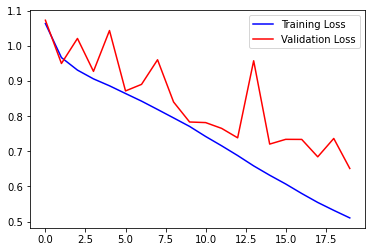

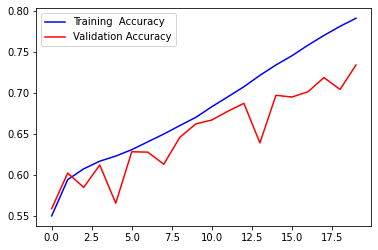

In [18]:
plt.plot(model.history.history['loss'],color='b', label='Training Loss')
plt.plot(model.history.history['val_loss'],color='r', label='Validation Loss')
plt.legend()
plt.show()
plt.plot(model.history.history['accuracy'],color='b', label='Training  Accuracy')
plt.plot(model.history.history['val_accuracy'],color='r', label='Validation Accuracy')
plt.legend()
plt.show()

1172/1172 [==============================] - 3s 3ms/step


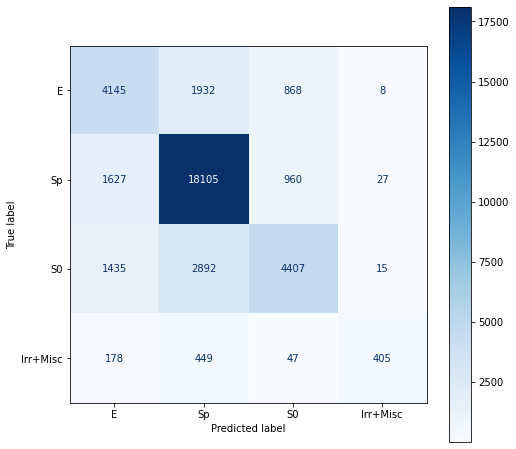

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

predictions = model.predict(X_test)
predictions = (predictions > 0.5) 
labels = ["E", "Sp", "S0", "Irr+Misc"]

cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()